## Uplift-моделирование

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation

from catboost import CatBoostClassifier

%matplotlib inline

In [2]:
df_init = pd.read_csv('data/web4/customer-retention-data.csv')
df_init.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df = df_init.copy()

# ДЗ п2
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

# one-hot
df = pd.get_dummies(df, columns=['zip_code', 'channel'], drop_first=True, dtype='int8')

# standart scaller to history column
df['history'] = StandardScaler().fit_transform(df[['history']].values)

df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,-0.389003,1,0,0,1,0,1,0,1,0
1,6,0.339614,1,1,1,0,0,0,0,0,1
2,7,-0.239836,0,1,1,1,0,1,0,0,1
3,9,1.693278,1,0,1,1,0,0,0,0,1
4,2,-0.768068,1,0,0,1,0,0,1,0,1


In [4]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recency             64000 non-null  int64  
 1   history             64000 non-null  float64
 2   used_discount       64000 non-null  int64  
 3   used_bogo           64000 non-null  int64  
 4   is_referral         64000 non-null  int64  
 5   treatment           64000 non-null  int64  
 6   target              64000 non-null  int64  
 7   zip_code_Surburban  64000 non-null  int8   
 8   zip_code_Urban      64000 non-null  int8   
 9   channel_Phone       64000 non-null  int8   
 10  channel_Web         64000 non-null  int8   
dtypes: float64(1), int64(6), int8(4)
memory usage: 3.7 MB


In [6]:
target_feature = 'target'

X = df.drop(target_feature, axis=1)
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

treat_train = X_train['treatment']
treat_val = X_test['treatment']
treat_train_full = X['treatment']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1.1 Одна модель

uplift@30%: 0.0939


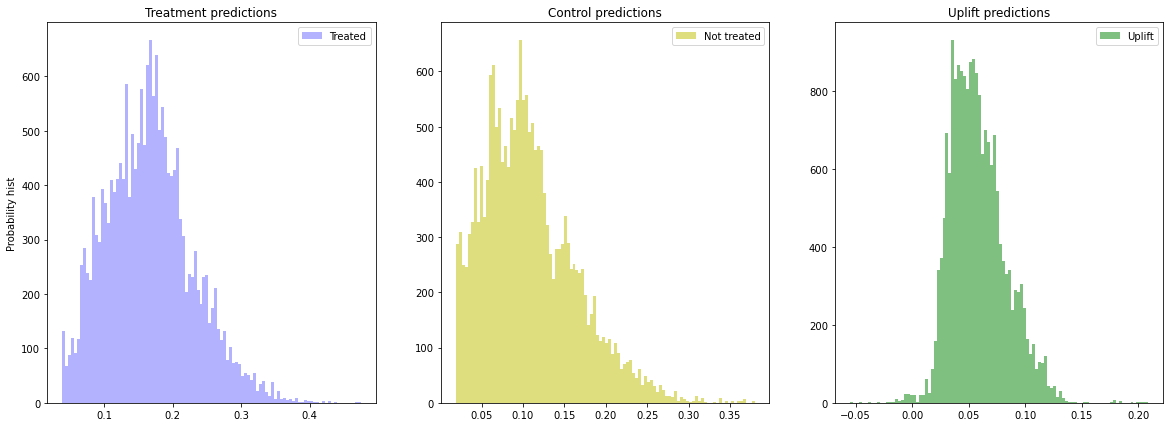

In [7]:
cat_model = CatBoostClassifier(
    iterations=20,
    random_state=42,
    silent=True,
)

sm = SoloModel(cat_model)
sm = sm.fit(
    X_train,
    y_train,
    treat_train,
)

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(
    y_true=y_test,
    uplift=uplift_sm,
    treatment=treat_val,
    strategy='by_group',
    k=0.3
)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [8]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.524806
1,history,15.186515
2,treatment,14.391480
3,recency,14.275645
4,used_bogo,10.342512
5,used_discount,9.131892
6,zip_code_Surburban,6.009640
7,channel_Web,4.987542
8,zip_code_Urban,4.437899
9,channel_Phone,2.712069


## 1.2 Трансформация классов

In [9]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

ipykernel_launcher:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


## 2.1 Две независимые модели

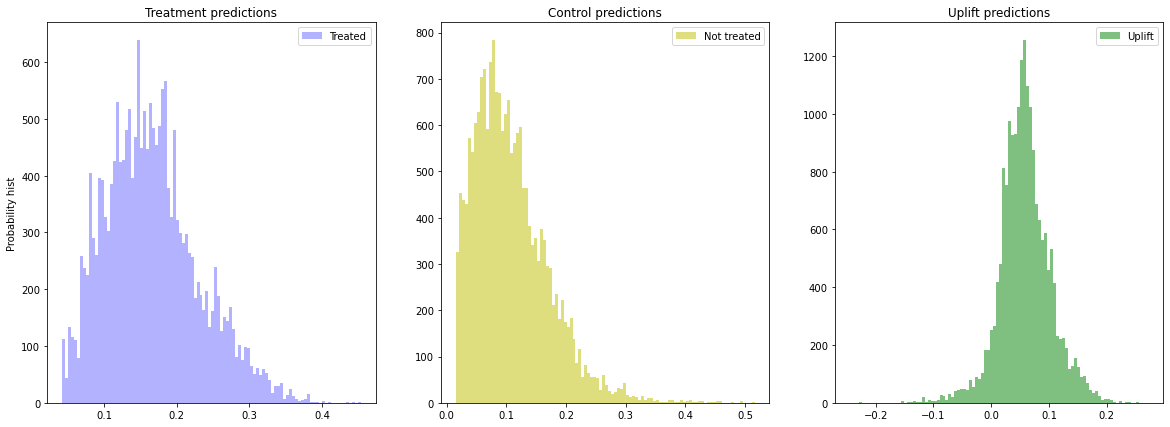

In [10]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Результаты

In [11]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.189062
0,SoloModel,0.093915
2,TwoModels,0.081670


## Вариант с деревом решений

Wall time: 10.8 s


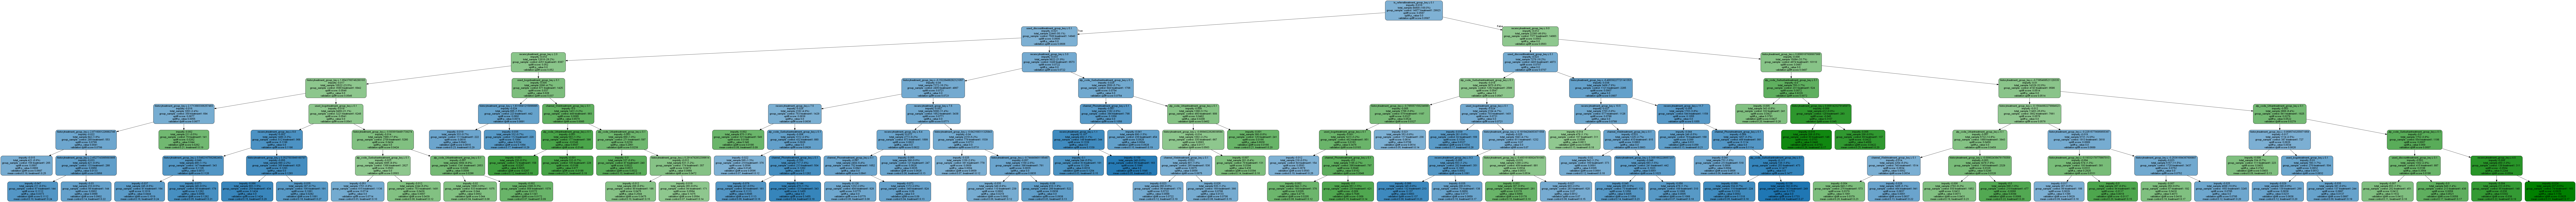

In [13]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(
    max_depth=8,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction='KL',
    control_name='control'
)

uplift_model.fit(
    X_train.values,
    treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
    y=y_train
)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())